[INFO] matrix_a=array([[-2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2., -2.]])
[INFO] vector_b=array([-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01])


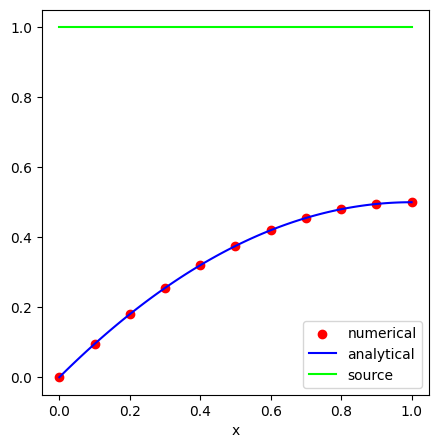

In [ ]:
"""総合演習2 マクロ系シミュレーション 第1回 例題1

1次元定常拡散方程式のシミュレーション(有限差分法)
"""

import sys
from typing import Final

import matplotlib.pyplot as plt
import numpy as np

# ========== パラメータ ==========
LX: Final[float] = 1      # 部屋のx方向の長さ(m)
D: Final[float] = 1       # 二酸化炭素の拡散係数(m^2/s)
C_OUT: Final[float] = 0   # 外気の二酸化炭素濃度(ppm)

NX: Final[int] = 11       # x方向の格子点数
# ==============================

# float型のNumPy配列の型エイリアス
FloatArray = np.typing.NDArray[np.float64]

# x方向の格子間隔
DX: float = LX / (NX - 1)


def func_src(x: float) -> float:
    """xにおける二酸化炭素の生成項を計算する

    Parameters
    ----------
    x : float
        x座標

    Returns
    -------
    float
        xにおける二酸化炭素の生成項
    """

    return 1


def analytical_solution(x: float, lx: float, d: float, c_out: float) -> float:
    """xにおける解析解を計算する

    Parameters
    ----------
    x : float
        x座標
    lx : float
        部屋のx方向の長さ
    d : float
        二酸化炭素の拡散係数
    c_out : float
        外気の二酸化炭素濃度

    Returns
    -------
    float
        xにおける解析解
    """

    s0: float = func_src(x)

    return c_out + s0 * x * (2*lx - x) / (2*d)


class Variable:
    """格子点上の物理量を扱うクラス

    Attributes
    ----------
    value : FloatArray
        格子点上の物理量の値
    __name : str
        'grid_x', 'co2', 'src' のいずれか

    Notes
    -----
    Variableクラスの外で使用しない属性は, 変数名の最初にダンダー(__)をつけて隠蔽している
    """

    def __init__(self, nx: int, dx: float, name: str) -> None:
        """Variableクラスのイニシャライザ

        Parameters
        ----------
        nx : int
            x方向の格子点数
        dx : float
            x方向の格子間隔
        name : str
            'grid_x', 'co2', 'src' のいずれか
        """

        if name not in ['grid_x', 'co2', 'src']:
            print('[ERROR] Variableクラスのイニシャライザの引数が不適切です')
            sys.exit()
        self.__name: str = name

        self.value: FloatArray = np.empty(nx, dtype=np.float64)

        if name in ['grid_x', 'src']:
            x: float
            for ix in range(nx):
                x = dx * ix
                self.value[ix] = self.__set_initial_condition(x)

    def __set_initial_condition(self, x: float) -> float:
        """xにおける値を設定する

        Parameters
        ----------
        x : float
            x座標

        Returns
        -------
        float
            xにおける値
        """

        if self.__name == 'grid_x':
            return x
        if self.__name == 'src':
            return func_src(x)


def create_a(nx: int) -> FloatArray:
    """係数行列Aを作成する

    Parameters
    ----------
    nx : int
        x方向の格子点数

    Returns
    -------
    matrix_a : FloatArray
        係数行列A
    """

    ##### ここを作成してください #####

    return matrix_a


def create_b(d: float, c_out: float, nx: int, dx: float, src: Variable) -> FloatArray:
    """定ベクトルbを作成する

    Parameters
    ----------
    d : float
        二酸化炭素の拡散係数
    c_out : float
        外気の二酸化炭素濃度
    nx : int
        x方向の格子点数
    dx : float
        x方向の格子間隔
    src : Variable
        二酸化炭素の生成項

    Returns
    -------
    vector_b : FloatArray
        定ベクトルb
    """

    matrix_size: int = nx - 1
    vector_b: FloatArray = np.zeros(matrix_size, dtype=np.float64)

    # 1行目 (x=x_1 の差分式から始まるので src.value[1] であることに注意)
    vector_b[0] = -src.value[1] * (dx**2) / d - c_out

    # 2行目〜(nx-1)行目 (1行目と同じく src.value[i+1] に注意)
    for i in range(1, matrix_size):
        vector_b[i] = -src.value[i+1] * (dx**2) / d

    return vector_b


if __name__ == '__main__':

    # Variableクラスのインスタンスとして変数を準備
    grid_x: Variable = Variable(NX, DX, 'grid_x')
    co2: Variable = Variable(NX, DX, 'co2')
    src: Variable = Variable(NX, DX, 'src')

    # 係数行列Aと定ベクトルbを作成
    matrix_a: FloatArray = create_a(NX)
    vector_b: FloatArray = create_b(D, C_OUT, NX, DX, src)
    print(f'[INFO] {matrix_a=}')
    print(f'[INFO] {vector_b=}')

    if not (matrix_a.shape[0] == matrix_a.shape[1] == vector_b.shape[0]):
        print('[ERROR] 係数行列Aまたは定ベクトルbのサイズが不適切です')
        sys.exit()

    # 連立方程式を解く
    co2.value[0] = C_OUT
    co2.value[1:] = np.linalg.solve(matrix_a, vector_b)

    # 数値解をプロット
    figure, axes = plt.subplots(1, 1, figsize=(5, 5))
    plt.scatter(grid_x.value, co2.value, c='red', label='numerical')

    # 解析解と生成項をプロット
    lin_x: FloatArray = np.linspace(0, LX, 100, dtype=np.float64)
    array_sol: FloatArray = np.array([analytical_solution(x, LX, D, C_OUT) for x in lin_x], dtype=np.float64)
    array_src: FloatArray = np.array([func_src(x) for x in lin_x], dtype=np.float64)
    plt.plot(lin_x, array_sol, c='blue', label='analytical')
    plt.plot(lin_x, array_src, c='lime', label='source')
    axes.set_xlabel('x')
    plt.legend()
